In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('hacktrain.csv', index_col=0)

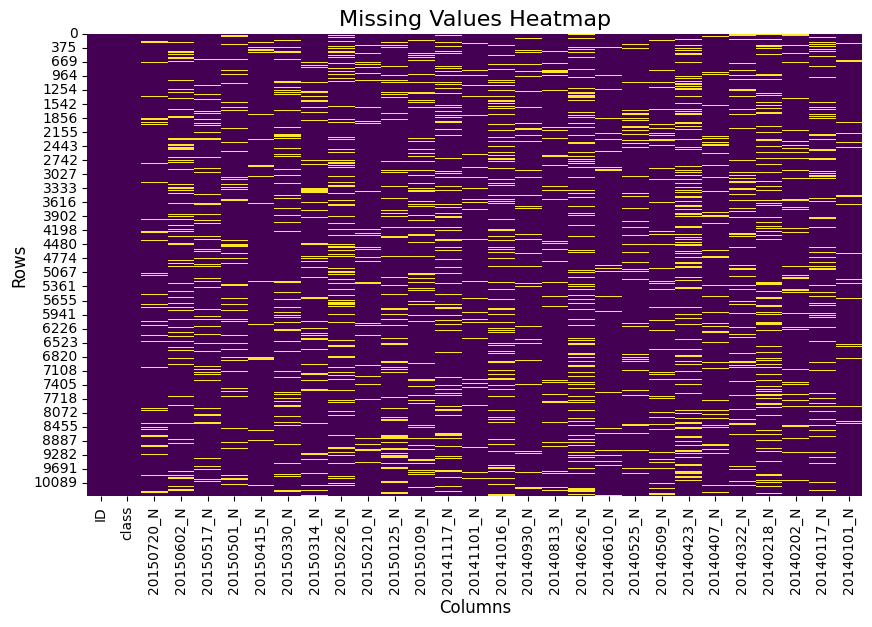

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Customize the plot
plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)

# Show the plot
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve

# 1. Load and preprocess data
df = pd.read_csv('hacktrain.csv')
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# Handle missing values
imputer = KNNImputer(n_neighbors=5)
df[ndvi_cols] = imputer.fit_transform(df[ndvi_cols])
trained_imputer = imputer

# 2. Enhanced Feature Engineering
def add_temporal_features(df, ndvi_cols):
    df['rolling_mean_3'] = df[ndvi_cols].rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = df[ndvi_cols].rolling(window=5, axis=1).max().mean(axis=1)
    threshold = 0.4
    above_threshold = df[ndvi_cols] > threshold
    df['growing_season_length'] = above_threshold.sum(axis=1)
    df['peak_ndvi'] = df[ndvi_cols].max(axis=1)
    df['ndvi_std_6mo'] = df[ndvi_cols].iloc[:, :6].std(axis=1)
    return df

df = add_temporal_features(df, ndvi_cols)
feature_cols = ndvi_cols + ['rolling_mean_3', 'rolling_max_5', 
                           'growing_season_length', 'peak_ndvi', 'ndvi_std_6mo']

# 3. Encode labels
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values  # Now has 32 features

# 4. Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Apply SMOTE and class weights
class_mapping = {name: idx for idx, name in enumerate(le.classes_)}
smote = SMOTE(sampling_strategy={
    class_mapping['orchard']:200 ,
    class_mapping['water']: 150,
    class_mapping['grass']: 200
}, random_state=42, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_train, y_train)

class_weights = {
    class_mapping['farm']: 6,
    class_mapping['forest']: 4,
    class_mapping['grass']: 6,
    class_mapping['impervious']: 3,
    class_mapping['orchard']: 20,
    class_mapping['water']: 1
}

# 6. Train model
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
model = LogisticRegression(
    solver='saga',
    penalty='elasticnet',  # Hybrid L1/L2 regularization
    l1_ratio=.01,          # Balance between L1 and L2
    C=.9,                 # Strong regularization for noisy imputed data
    max_iter=8000,
    class_weight=class_weights,
    random_state=40
)

model.fit(X_res_scaled, y_res)

# 7. Validate (critical fix: scale X_val with the same scaler)
X_val_scaled = scaler.transform(X_val)  

y_pred = model.predict(X_val_scaled)


print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred, target_names=le.classes_))


Validation Accuracy: 0.8981
              precision    recall  f1-score   support

        farm       0.69      0.60      0.64       168
      forest       0.95      0.96      0.96      1232
       grass       0.72      0.59      0.65        39
  impervious       0.90      0.81      0.85       134
     orchard       0.12      0.83      0.22         6
       water       0.81      0.62      0.70        21

    accuracy                           0.90      1600
   macro avg       0.70      0.74      0.67      1600
weighted avg       0.91      0.90      0.90      1600



/home/robo/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Suppress warnings from the SAGA solver for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# 1. Load and preprocess data
df = pd.read_csv('hacktrain.csv')
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# Apply your chosen imputation strategy
df[ndvi_cols] = df[ndvi_cols].interpolate(method='linear')
df[ndvi_cols] = df[ndvi_cols].fillna(method='bfill')

# 2. Enhanced Feature Engineering
def add_temporal_features(df, ndvi_cols):
    df['rolling_mean_3'] = df[ndvi_cols].rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = df[ndvi_cols].rolling(window=5, axis=1).max().mean(axis=1)
    threshold = 0.4
    above_threshold = df[ndvi_cols] > threshold
    df['growing_season_length'] = above_threshold.sum(axis=1)
    df['peak_ndvi'] = df[ndvi_cols].max(axis=1)
    # Ensure there are enough columns for this feature
    if len(ndvi_cols) >= 6:
        df['ndvi_std_6mo'] = df[ndvi_cols].iloc[:, :6].std(axis=1)
    else:
        df['ndvi_std_6mo'] = df[ndvi_cols].std(axis=1) # Fallback
    return df

df = add_temporal_features(df, ndvi_cols)
feature_cols = ndvi_cols + ['rolling_mean_3', 'rolling_max_5',
                           'growing_season_length', 'peak_ndvi', 'ndvi_std_6mo']

# Fill any NaNs created by rolling features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

# 3. Prepare data for CV
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values

# 4. Define class mapping and weights for use inside the loop
class_mapping = {name: idx for idx, name in enumerate(le.classes_)}
class_weights = {
    class_mapping['farm']: .9,
    class_mapping['forest']: 1,
    class_mapping['grass']: .7,
    class_mapping['impervious']: .9,
    class_mapping['orchard']: .5,
    class_mapping['water']: .6
}

# 5. Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
reports = []

print("Starting 5-fold Stratified Cross-Validation...")
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {i+1}/5 ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # --- Apply SMOTE only to the training data of this fold ---
    smote = SMOTE(sampling_strategy={
        class_mapping['orchard']: 100,
        class_mapping['water']: 150,
        class_mapping['grass']: 190
    }, random_state=42, k_neighbors=3)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    # --- Scale data based ONLY on this fold's training set ---
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_val_scaled = scaler.transform(X_val) # Use the same scaler for validation set

    # --- Train model on this fold's resampled and scaled training data ---
    model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.03,
        C=2,
        max_iter=8000,
        class_weight=class_weights,
        random_state=40
    )
    model.fit(X_res_scaled, y_res)

    # --- Validate and store results ---
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    # Store the report dictionary for later analysis
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
    reports.append(report)

# 6. Final Results
print("\n--- Cross-Validation Summary ---")
avg_accuracy = np.mean(accuracies)
print(f"Average Validation Accuracy: {avg_accuracy:.4f} (+/- {np.std(accuracies):.4f})")

# Display the classification report for the last fold as an example
print("\nClassification Report (last fold):")
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

# 7. Load and process the test data
print("\n--- Processing Test Data for Submission ---")
try:
    df_test = pd.read_csv('hacktest.csv')
    print("Test data loaded successfully.")
except FileNotFoundError:
    print("Error: 'hacktest.csv' not found. Please ensure the file is in the correct directory.")
    # Exit or handle the error as appropriate
    exit()

# Re-use the same NDVI column identifier and imputation strategy
ndvi_cols_test = [col for col in df_test.columns if col.endswith('_N')]
df_test[ndvi_cols_test] = df_test[ndvi_cols_test].interpolate(method='linear')
df_test[ndvi_cols_test] = df_test[ndvi_cols_test].fillna(method='bfill')

# 8. Apply the same feature engineering to the test data
df_test = add_temporal_features(df_test, ndvi_cols_test)

# Ensure the feature columns match the training set
feature_cols = ndvi_cols + ['rolling_mean_3', 'rolling_max_5',
                           'growing_season_length', 'peak_ndvi', 'ndvi_std_6mo']

# Fill any NaNs created by rolling features, using means from the test set itself
df_test[feature_cols] = df_test[feature_cols].fillna(df_test[feature_cols].mean())

# Prepare the test data array
X_test = df_test[feature_cols].values
print(f"Test data shape after feature engineering: {X_test.shape}")


# 9. Scale the test data using the scaler from the training phase
# IMPORTANT: Use .transform() only, do not re-fit the scaler on test data
X_test_scaled = scaler.transform(X_test)

# 10. Predict classes for the test data using the trained model
test_predictions_numeric = model.predict(X_test_scaled)

# 11. Convert numeric predictions back to original class labels
test_predictions_labels = le.inverse_transform(test_predictions_numeric)

# 12. Create the submission file with the corrected column name 'ID'
submission_df = pd.DataFrame({
    'ID': df_test['ID'],  # Corrected from 'id' to 'ID'
    'class': test_predictions_labels
})

# Save to CSV in the specified format
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' has been created successfully.")
print(f"Submission file preview:\n{submission_df.head()}")

Starting 5-fold Stratified Cross-Validation...

--- Fold 1/5 ---
Fold 1 Accuracy: 0.9313

--- Fold 2/5 ---
Fold 2 Accuracy: 0.9181

--- Fold 3/5 ---
Fold 3 Accuracy: 0.9219

--- Fold 4/5 ---
Fold 4 Accuracy: 0.9300

--- Fold 5/5 ---
Fold 5 Accuracy: 0.9213

--- Cross-Validation Summary ---
Average Validation Accuracy: 0.9245 (+/- 0.0052)

Classification Report (last fold):
              precision    recall  f1-score   support

        farm       0.83      0.64      0.72       168
      forest       0.94      0.98      0.96      1231
       grass       0.82      0.68      0.74        40
  impervious       0.85      0.88      0.86       134
     orchard       0.25      0.17      0.20         6
       water       0.86      0.57      0.69        21

    accuracy                           0.92      1600
   macro avg       0.76      0.65      0.70      1600
weighted avg       0.92      0.92      0.92      1600


--- Processing Test Data for Submission ---
Test data loaded successfully.
Test 

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Load and preprocess data
df = pd.read_csv('hacktrain.csv')
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# Fill missing values
df[ndvi_cols] = df[ndvi_cols].interpolate(method='linear').fillna(method='bfill')
print("Remaining NaNs:", df[ndvi_cols].isnull().sum().sum())

# 2. Basic Feature Engineering (only essential features)
df['peak_ndvi'] = df[ndvi_cols].max(axis=1)  # Single most important feature
feature_cols = ndvi_cols + ['peak_ndvi']

# 3. Encode labels
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values

# 4. Initialize Stratified K-Fold (5 splits)
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
scaler = StandardScaler()
model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.5,
        C=0.9,
        max_iter=8000,
        random_state=40
    )

# 5. Cross-validation loop
val_accuracies = []

for train_idx, val_idx  in skf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Scale data (fit only on training)
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    val_accuracies.append(accuracy_score(y_val, y_pred))
#     print(classification_report(y_val, y_pred, target_names=le.classes_))
    

print(f"\nAverage Validation Accuracy: {np.mean(val_accuracies):.4f} (±{np.std(val_accuracies):.4f})")

# 6. (Optional) Final train-test split evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print("\nFinal Test Performance:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Remaining NaNs: 0

Average Validation Accuracy: 0.9154 (±0.0151)

Final Test Performance:
              precision    recall  f1-score   support

        farm       0.78      0.59      0.67       168
      forest       0.94      0.98      0.96      1232
       grass       0.86      0.49      0.62        39
  impervious       0.82      0.86      0.84       134
     orchard       0.33      0.17      0.22         6
       water       0.78      0.67      0.72        21

    accuracy                           0.91      1600
   macro avg       0.75      0.63      0.67      1600
weighted avg       0.91      0.91      0.91      1600



In [5]:
import pandas as pd

# 1. Load test data
test_df = pd.read_csv('hacktest.csv')

# 2. Identify NDVI columns (should match training NDVI columns order!)
ndvi_cols = [col for col in test_df.columns if col.endswith('_N')]

# 3. Impute missing NDVI values using the TRAINED imputer
test_df[ndvi_cols] = trained_imputer.transform(test_df[ndvi_cols])  # Use the imputer from training

# 4. Feature engineering (must match training exactly: ONLY 5 engineered features)
def add_temporal_features(df, ndvi_cols):
    df['rolling_mean_3'] = df[ndvi_cols].rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = df[ndvi_cols].rolling(window=5, axis=1).max().mean(axis=1)
    threshold = 0.4
    above_threshold = df[ndvi_cols] > threshold
    df['growing_season_length'] = above_threshold.sum(axis=1)
    df['peak_ndvi'] = df[ndvi_cols].max(axis=1)
    df['ndvi_std_6mo'] = df[ndvi_cols].iloc[:, :6].std(axis=1)
    return df

test_df = add_temporal_features(test_df, ndvi_cols)

# 5. Prepare test features (must match training order: 27 NDVI + 5 features = 32)
feature_cols = ndvi_cols + [
    'rolling_mean_3', 'rolling_max_5', 
    'growing_season_length', 'peak_ndvi', 'ndvi_std_6mo'
]
X_test = test_df[feature_cols].values

# 6. Scale features using the scaler from training
X_test_scaled = scaler.transform(X_test)  # scaler must be from training

# 7. Predict using your trained model
y_test_pred = model.predict(X_test_scaled)

# 8. Decode labels using your trained label encoder
predicted_classes = le.inverse_transform(y_test_pred)  # le from training

# 9. Prepare submission DataFrame
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'class': predicted_classes
})

# 10. Save to CSV in the required format
submission.to_csv('submission.csv', index=False)
print("submission.csv created!")
print(submission.head())


submission.csv created!
   ID    class
0   1  orchard
1   2  orchard
2   3  orchard
3   4  orchard
4   5  orchard


In [19]:
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np # linear algebra

#read cds
df = pd.read_csv("hacktrain.csv")

# Step 1: Identify NDVI columns
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# Step 2: Interpolate missing NDVI values row-wise
df[ndvi_cols] = df[ndvi_cols].interpolate(method='linear', axis=1, limit_direction='both')

# Drop ID column
df.drop(columns=['ID'], inplace=True)

# Encode class column (if it's categorical)
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

# Split into features and target
X = df.drop(columns=['class'])
y = df['class']

# # Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit multinomial logistic regression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    # class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Classification report with all original class labels
print(classification_report(
    y_test,
    y_pred,
    labels=list(range(len(label_encoder.classes_))),
    target_names=label_encoder.classes_
))
acc = accuracy_score(y_test, y_pred)
acc

              precision    recall  f1-score   support

        farm       0.84      0.86      0.85       168
      forest       0.99      0.99      0.99      1232
       grass       0.77      0.59      0.67        39
  impervious       0.83      0.89      0.86       134
     orchard       0.67      0.33      0.44         6
       water       0.80      0.76      0.78        21

    accuracy                           0.95      1600
   macro avg       0.82      0.74      0.77      1600
weighted avg       0.95      0.95      0.95      1600



0.955

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import warnings
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Load and Preprocess Data ---
try:
    df = pd.read_csv('hacktrain.csv')
    df_test = pd.read_csv('hacktest.csv')
    print("Training and test data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure 'hacktrain.csv' and 'hacktest.csv' are in the correct directory.")
    exit()

# Identify NDVI columns and apply imputation
ndvi_cols = [col for col in df.columns if col.endswith('_N')]
df[ndvi_cols] = df[ndvi_cols].interpolate(method='linear', axis=1, limit_direction='both')
df_test[ndvi_cols] = df_test[ndvi_cols].interpolate(method='linear', axis=1, limit_direction='both')

# --- 2. Enhanced Feature Engineering ---
# IMPROVEMENT: Added features to capture temporal dynamics like the timing of peak growth.
def add_temporal_features(df, ndvi_cols):
    """Adds rolling, aggregate, and temporal dynamic features."""
    ndvi_data = df[ndvi_cols]
    
    # Original features
    df['rolling_mean_3'] = ndvi_data.rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = ndvi_data.rolling(window=5, axis=1).max().mean(axis=1)
    df['growing_season_length'] = (ndvi_data > 0.4).sum(axis=1)
    df['peak_ndvi'] = ndvi_data.max(axis=1)
    
    # Standard deviation over the first 6 months
    if len(ndvi_cols) >= 6:
        df['ndvi_std_6mo'] = ndvi_data.iloc[:, :6].std(axis=1)
    else:
        df['ndvi_std_6mo'] = ndvi_data.std(axis=1)
        
    # --- NEW FEATURES ---
    # Feature 1: Timing of the peak NDVI (which month index)
    # This helps distinguish crops with different phenology (growth cycles)
    df['peak_time_index'] = np.argmax(ndvi_data.values, axis=1)
    
    # Feature 2: "Green-up" slope (early season growth rate)
    if len(ndvi_cols) >= 4:
        df['green_up_slope'] = ndvi_data.iloc[:, 3] - ndvi_data.iloc[:, 0]
    else:
        df['green_up_slope'] = 0 # Fallback
        
    return df

# Apply feature engineering to both train and test sets
df = add_temporal_features(df, ndvi_cols)
df_test = add_temporal_features(df_test, ndvi_cols)

# Define the full list of features to be used
feature_cols = ndvi_cols + [
    'rolling_mean_3', 'rolling_max_5', 'growing_season_length', 'peak_ndvi', 
    'ndvi_std_6mo', 'peak_time_index', 'green_up_slope'
]

# Fill any NaNs created by rolling features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())
df_test[feature_cols] = df_test[feature_cols].fillna(df_test[feature_cols].mean())


# --- 3. Prepare Data for Cross-Validation ---
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values
class_mapping = {name: idx for idx, name in enumerate(le.classes_)}


# --- 4. Stratified K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
reports = []
final_model = None
final_scaler = None

print("Starting 5-fold Stratified Cross-Validation...")
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {i+1}/5 ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # --- Apply SMOTE only to the training data of this fold ---
    train_counts = Counter(y_train)
    
    # IMPROVEMENT: Dynamic and more aggressive SMOTE strategy
    # Upsample minority classes to be a fraction of the 'farm' class count
    target_farm_count = train_counts[class_mapping['farm']]
    smote_strategy = {
        class_mapping['orchard']: int(target_farm_count * 1.0), # Bring orchard up to farm level
        class_mapping['water']: int(target_farm_count * 0.8),
        class_mapping['grass']: int(target_farm_count * 0.7)
    }
    
    # IMPROVEMENT: Dynamically set k_neighbors to prevent errors with small classes
    orchard_count = train_counts.get(class_mapping['orchard'], 0)
    k_neighbors = max(1, orchard_count - 1)
    
    if k_neighbors > 0:
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=k_neighbors)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        print(f"Original training distribution: {train_counts}")
        print(f"Resampled training distribution: {Counter(y_res)}")
    else:
        print("Skipping SMOTE for this fold as 'orchard' class has too few samples.")
        X_res, y_res = X_train, y_train


    # --- Scale data based ONLY on this fold's resampled training set ---
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_val_scaled = scaler.transform(X_val)

    # --- Train model on this fold's data ---
    # IMPROVEMENT: Use class_weight='balanced' to automatically handle imbalance
    model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.3,
        C=2,
        max_iter=8000,
        class_weight='balanced', # Key improvement
        random_state=40
    )
    model.fit(X_res_scaled, y_res)

    # --- Validate and store results ---
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
    reports.append(report)
    
    # Save the model and scaler from the last fold for submission
    if i == skf.get_n_splits() - 1:
        final_model = model
        final_scaler = scaler

# --- 5. Final Results Summary ---
print("\n--- Cross-Validation Summary ---")
avg_accuracy = np.mean(accuracies)
print(f"Average Validation Accuracy: {avg_accuracy:.4f} (+/- {np.std(accuracies):.4f})")

# Display the classification report for the last fold
print("\nClassification Report (last fold):")
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

# --- 6. Process Test Data and Create Submission ---
print("\n--- Processing Test Data for Submission ---")
X_test = df_test[feature_cols].values
print(f"Test data shape after feature engineering: {X_test.shape}")

# Scale the test data using the scaler from the final training fold[1]
X_test_scaled = final_scaler.transform(X_test)

# Predict classes for the test data
test_predictions_numeric = final_model.predict(X_test_scaled)

# Convert numeric predictions back to original class labels
test_predictions_labels = le.inverse_transform(test_predictions_numeric)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'ID': df_test['ID'],
    'class': test_predictions_labels
})

# Save to CSV
submission_df.to_csv('submission_improved.csv', index=False)

print("\n'submission_improved.csv' has been created successfully.")
print(f"Submission file preview:\n{submission_df.head()}")


Training and test data loaded successfully.
Starting 5-fold Stratified Cross-Validation...

--- Fold 1/5 ---
Original training distribution: Counter({1: 4927, 0: 673, 3: 535, 2: 157, 5: 84, 4: 24})
Resampled training distribution: Counter({1: 4927, 0: 673, 4: 673, 5: 538, 3: 535, 2: 471})
Fold 1 Accuracy: 0.7894

--- Fold 2/5 ---
Original training distribution: Counter({1: 4927, 0: 673, 3: 535, 2: 157, 5: 84, 4: 24})
Resampled training distribution: Counter({1: 4927, 0: 673, 4: 673, 5: 538, 3: 535, 2: 471})
Fold 2 Accuracy: 0.7969

--- Fold 3/5 ---
Original training distribution: Counter({1: 4927, 0: 673, 3: 535, 2: 157, 5: 84, 4: 24})
Resampled training distribution: Counter({1: 4927, 0: 673, 4: 673, 5: 538, 3: 535, 2: 471})
Fold 3 Accuracy: 0.7831

--- Fold 4/5 ---
Original training distribution: Counter({1: 4927, 0: 672, 3: 536, 2: 157, 5: 84, 4: 24})
Resampled training distribution: Counter({1: 4927, 0: 672, 4: 672, 5: 537, 3: 536, 2: 470})
Fold 4 Accuracy: 0.7963

--- Fold 5/5 ---

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier # CHANGED: Switched to RandomForest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import warnings
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Load and Preprocess Data ---
try:
    df = pd.read_csv('hacktrain.csv')
    df_test = pd.read_csv('hacktest.csv')
    print("Training and test data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure 'hacktrain.csv' and 'hacktest.csv' are in the correct directory.")
    exit()

# Identify NDVI columns and apply imputation
ndvi_cols = [col for col in df.columns if col.endswith('_N')]
df[ndvi_cols] = df[ndvi_cols].interpolate(method='linear', axis=1, limit_direction='both')
df_test[ndvi_cols] = df_test[ndvi_cols].interpolate(method='linear', axis=1, limit_direction='both')

# --- 2. Enhanced Feature Engineering ---
def add_temporal_features(df, ndvi_cols):
    """Adds rolling, aggregate, and temporal dynamic features."""
    ndvi_data = df[ndvi_cols]
    
    df['rolling_mean_3'] = ndvi_data.rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = ndvi_data.rolling(window=5, axis=1).max().mean(axis=1)
    df['growing_season_length'] = (ndvi_data > 0.4).sum(axis=1)
    df['peak_ndvi'] = ndvi_data.max(axis=1)
    
    if len(ndvi_cols) >= 6:
        df['ndvi_std_6mo'] = ndvi_data.iloc[:, :6].std(axis=1)
    else:
        df['ndvi_std_6mo'] = ndvi_data.std(axis=1)
        
    df['peak_time_index'] = np.argmax(ndvi_data.values, axis=1)
    
    if len(ndvi_cols) >= 4:
        df['green_up_slope'] = ndvi_data.iloc[:, 3] - ndvi_data.iloc[:, 0]
    else:
        df['green_up_slope'] = 0
        
    return df

# Apply feature engineering to both train and test sets
df = add_temporal_features(df, ndvi_cols)
df_test = add_temporal_features(df_test, ndvi_cols)

# Define the full list of features to be used
feature_cols = ndvi_cols + [
    'rolling_mean_3', 'rolling_max_5', 'growing_season_length', 'peak_ndvi', 
    'ndvi_std_6mo', 'peak_time_index', 'green_up_slope'
]

# Fill any NaNs created by rolling features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())
df_test[feature_cols] = df_test[feature_cols].fillna(df_test[feature_cols].mean())


# --- 3. Prepare Data for Cross-Validation ---
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values
class_mapping = {name: idx for idx, name in enumerate(le.classes_)}


# --- 4. Stratified K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
final_model = None
final_scaler = None

print("Starting 5-fold Stratified Cross-Validation with RandomForestClassifier...")
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {i+1}/5 ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # --- Apply SMOTE only to the training data of this fold ---
    train_counts = Counter(y_train)
    
    # IMPROVEMENT: A more balanced SMOTE strategy
    smote_strategy = {
        class_mapping['orchard']: 800,
        class_mapping['water']: 800,
        class_mapping['grass']: 800
    }
    
    orchard_count = train_counts.get(class_mapping['orchard'], 0)
    k_neighbors = max(1, orchard_count - 1)
    
    if k_neighbors > 0:
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=k_neighbors)
        X_res, y_res = smote.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Scale data based on this fold's resampled training set[1]
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_val_scaled = scaler.transform(X_val)

    # --- Train a more powerful model on this fold's data ---
    # IMPROVEMENT: Switched to RandomForestClassifier for better performance
    model = RandomForestClassifier(
        n_estimators=250,       # More trees for a more robust model
        max_depth=20,           # Control tree depth to prevent overfitting
        min_samples_leaf=3,     # Smoothen the model by requiring more samples per leaf
        class_weight='balanced',# Let the model handle class imbalance
        random_state=42,
        n_jobs=-1               # Use all available CPU cores
    )
    model.fit(X_res_scaled, y_res)

    # --- Validate and store results ---
    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    if i == skf.get_n_splits() - 1:
        final_model = model
        final_scaler = scaler
        print("\nClassification Report (last fold):")
        print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

# --- 5. Final Results Summary ---
print("\n--- Cross-Validation Summary ---")
avg_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
print(f"Average Validation Accuracy: {avg_accuracy:.4f} (+/- {std_dev:.4f})")

# --- 6. Process Test Data and Create Submission ---
print("\n--- Processing Test Data for Submission ---")
X_test = df_test[feature_cols].values

# Scale the test data using the scaler from the final training fold
X_test_scaled = final_scaler.transform(X_test)

# Predict classes for the test data
test_predictions_numeric = final_model.predict(X_test_scaled)
test_predictions_labels = le.inverse_transform(test_predictions_numeric)

# Create submission file
submission_df = pd.DataFrame({'ID': df_test['ID'], 'class': test_predictions_labels})
submission_df.to_csv('submission_rf_improved.csv', index=False)

print("\n'submission_rf_improved.csv' has been created successfully.")
print(f"Submission file preview:\n{submission_df.head()}")


Training and test data loaded successfully.
Starting 5-fold Stratified Cross-Validation with RandomForestClassifier...

--- Fold 1/5 ---
Fold 1 Accuracy: 0.9394

--- Fold 2/5 ---
Fold 2 Accuracy: 0.9419

--- Fold 3/5 ---
Fold 3 Accuracy: 0.9381

--- Fold 4/5 ---
Fold 4 Accuracy: 0.9363

--- Fold 5/5 ---
Fold 5 Accuracy: 0.9394

Classification Report (last fold):
              precision    recall  f1-score   support

        farm       0.85      0.78      0.81       168
      forest       0.96      0.99      0.97      1231
       grass       0.76      0.80      0.78        40
  impervious       0.91      0.83      0.87       134
     orchard       0.67      0.33      0.44         6
       water       0.82      0.67      0.74        21

    accuracy                           0.94      1600
   macro avg       0.83      0.73      0.77      1600
weighted avg       0.94      0.94      0.94      1600


--- Cross-Validation Summary ---
Average Validation Accuracy: 0.9390 (+/- 0.0018)

--- Proc

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import warnings
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Load Data ---
try:
    df = pd.read_csv('hacktrain.csv')
    df_test = pd.read_csv('hacktest.csv')
    print("Training and test data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure 'hacktrain.csv' and 'hacktest.csv' are in the correct directory.")
    exit()

# --- 2. New Imputation Strategy (Month-based Mean) ---
# Identify NDVI columns
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# IMPROVEMENT: Calculate the average for each month ONLY from the training data[1]
monthly_avg_ndvi = df[ndvi_cols].mean(axis=0)
print("\nCalculated Monthly Averages for Imputation:")
print(monthly_avg_ndvi)

# Apply these averages to fill NaNs in both the training and test sets[2]
df[ndvi_cols] = df[ndvi_cols].fillna(monthly_avg_ndvi)
df_test[ndvi_cols] = df_test[ndvi_cols].fillna(monthly_avg_ndvi)
print("\nMissing values imputed using monthly averages.")


# --- 3. Enhanced Feature Engineering ---
def add_temporal_features(df, ndvi_cols):
    """Adds rolling, aggregate, and temporal dynamic features."""
    ndvi_data = df[ndvi_cols]
    
    df['rolling_mean_3'] = ndvi_data.rolling(window=3, axis=1).mean().mean(axis=1)
    df['rolling_max_5'] = ndvi_data.rolling(window=5, axis=1).max().mean(axis=1)
    df['growing_season_length'] = (ndvi_data > 0.4).sum(axis=1)
    df['peak_ndvi'] = ndvi_data.max(axis=1)
    df['ndvi_std'] = ndvi_data.std(axis=1)
    df['peak_time_index'] = np.argmax(ndvi_data.values, axis=1)
    if len(ndvi_cols) >= 4:
        df['green_up_slope'] = ndvi_data.iloc[:, 3] - ndvi_data.iloc[:, 0]
    else:
        df['green_up_slope'] = 0
    return df

df = add_temporal_features(df, ndvi_cols)
df_test = add_temporal_features(df_test, ndvi_cols)

feature_cols = [
    'rolling_mean_3', 'rolling_max_5', 'growing_season_length', 'peak_ndvi', 
    'ndvi_std', 'peak_time_index', 'green_up_slope'
] + ndvi_cols

df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())
df_test[feature_cols] = df_test[feature_cols].fillna(df_test[feature_cols].mean())

# --- 4. Prepare Data for Cross-Validation ---
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df[feature_cols].values
class_mapping = {name: idx for idx, name in enumerate(le.classes_)}

# --- 5. Stratified K-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
final_model, final_poly, final_scaler = None, None, None

print("\nStarting 5-fold CV with Logistic Regression and Polynomial Features...")
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {i+1}/5 ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Moderate SMOTE Strategy
    train_counts = Counter(y_train)
    smote_strategy = {
        class_mapping['orchard']: 700,
        class_mapping['water']: 700,
        class_mapping['grass']: 700
    }
    k_neighbors = max(1, train_counts[class_mapping['orchard']] - 1)
    
    if k_neighbors > 0:
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=k_neighbors)
        X_res, y_res = smote.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Add Polynomial Features to capture non-linearities
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    X_res_poly = poly.fit_transform(X_res)
    X_val_poly = poly.transform(X_val)
    
    # Scale data AFTER creating polynomial features[3]
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res_poly)
    X_val_scaled = scaler.transform(X_val_poly)

    # Train Logistic Regression
    model = LogisticRegression(
        solver='saga', penalty='elasticnet', l1_ratio=0.15, C=10, 
        max_iter=10000, class_weight='balanced', random_state=42, n_jobs=-1
    )
    model.fit(X_res_scaled, y_res)

    y_pred = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
    
    if i == skf.get_n_splits() - 1:
        final_model, final_poly, final_scaler = model, poly, scaler
        print("\nClassification Report (last fold):")
        print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

# --- 6. Final Results Summary ---
print("\n--- Cross-Validation Summary ---")
avg_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
print(f"Average Validation Accuracy: {avg_accuracy:.4f} (+/- {std_dev:.4f})")

# --- 7. Process Test Data and Create Submission ---
print("\n--- Processing Test Data for Submission ---")
X_test = df_test[feature_cols].values

X_test_poly = final_poly.transform(X_test)
X_test_scaled = final_scaler.transform(X_test_poly)

test_predictions = final_model.predict(X_test_scaled)
test_predictions_labels = le.inverse_transform(test_predictions)

submission_df = pd.DataFrame({'ID': df_test['ID'], 'class': test_predictions_labels})
submission_df.to_csv('submission_logreg_final.csv', index=False)

print("\n'submission_logreg_final.csv' has been created successfully.")
print(f"Submission file preview:\n{submission_df.head()}")


Training and test data loaded successfully.

Calculated Monthly Averages for Imputation:
20150720_N    5845.476916
20150602_N    4868.091395
20150517_N    4469.837748
20150501_N    5193.485086
20150415_N    2927.586705
20150330_N    4924.493648
20150314_N    3313.881373
20150226_N    4987.520158
20150210_N    4320.961814
20150125_N    5237.037739
20150109_N    2217.826698
20141117_N    3262.549896
20141101_N    2613.621603
20141016_N    2801.923271
20140930_N    2416.228527
20140813_N    1570.869960
20140626_N    2990.753932
20140610_N    4872.681670
20140525_N    3674.886731
20140509_N    3012.178524
20140423_N    3055.167358
20140407_N    2041.316792
20140322_N    2799.820342
20140218_N    2144.360224
20140202_N    6259.064275
20140117_N    2629.203972
20140101_N    2578.449870
dtype: float64

Missing values imputed using monthly averages.

Starting 5-fold CV with Logistic Regression and Polynomial Features...

--- Fold 1/5 ---
Fold 1 Accuracy: 0.9319

--- Fold 2/5 ---
Fold 2 Accurac